In [1]:
import torch
from easy_transformer import EasyTransformer
from easy_transformer.hook_points import HookPoint

from dataclasses import dataclass, field
from typing import List, Tuple
from collections import defaultdict

import json
import gc
from tqdm import tqdm

import numpy as np

In [2]:
# This is used in order to ensure that there is no overlapping in target memory to edit
@dataclass
class Memory:
    subject : str
    relation : str
    objectif : str
    
    def __post_init__(self):
        self.s = self.subject
        self.r = self.relation
        self.o = self.objectif

@dataclass
class Request:
    # holding the Subject, Relation and Object to target
    mem : Memory
    prompt : str
    examples : List[str] = field(default_factory=list)


@dataclass
class RequestList:
    __requests : List[Request] = field(default_factory=list)

    def append(self, requests : List[Request]):
        # if requests not already a list, change it to one
        if type(requests) != list:
            requests = [requests]

        for request in requests:
            #region check for conflicting requets
            
            # Check if there is no conflicting (subject, relation)
            # if there is one, just skip this request
            skip = False
            for i, saved_request in enumerate(self.__requests): 
                
                # get the memory elements from saved request and current request
                saved_s, saved_r, *_ = saved_request.mem.__dict__.values()
                s, r, *_ = request.mem.__dict__.values()

                if saved_s == s and saved_r == r:
                    print(f"skipping ({s},{r}) because it is in conflict with ({saved_s},{saved_r}) at index {i}")
                    skip = True
                    continue
            if skip:
                continue
            
            #endregion
            self.__requests.append(request)


In [3]:
requests = RequestList()
requests.append([
    Request(
        mem=Memory("Lebron James", "play sport", "Football"), 
        prompt="{} is playing the sport of", 
        examples=[
            "Lebron James was famousely known for"
        ]
    ),
])

In [4]:
# Must be one of
# ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'facebook/opt-125m', 'facebook/opt-1.3b', 'facebook/opt-2.7b', 'facebook/opt-6.7b', 'facebook/opt-13b', 'facebook/opt-30b', 'facebook/opt-66b', 'EleutherAI/gpt-neo-125M', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-neo-2.7B', 'EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b']
MODEL_NAME = "gpt2-xl"

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EasyTransformer.from_pretrained(MODEL_NAME)
model.reset_hooks()

model.to(device)

torch.cuda.empty_cache()
gc.collect()

Using pad_token, but it is not set yet.


Moving model to device:  cuda
Finished loading pretrained model gpt2-xl into EasyTransformer!
Moving model to device:  cuda


8

In [6]:
prompt_datasets = json.load(open("./known_fact_dataset.json", "r+"))

# Causal tracing

In [7]:
def untuple(x):
    return x[0] if isinstance(x, tuple) else x

In [8]:
def layername(num=0, _type=None):
    # Layer translation for top level hooks on EasyTranformer
    supported_hooks = ["embed", "pos_embed", "resid_pre", "resid_mid", "resid_post", "attn_out", "mlp_out"]
    assert _type in supported_hooks, f"type must be one of {supported_hooks}"
    
    if _type == "embed":
        return "hook_embed"
    
    if _type == "pos_embed":
        return "hook_pos_embed"

    return f"blocks.{num}.hook_{_type}"

In [9]:
def inputs_toks(model : EasyTransformer, _inputs : List[str]):
    return [model.tokenizer.tokenize(i) for i in _inputs]

def inputs_toks_ids(model : EasyTransformer, _inputs : List[str]):
    return [model.tokenizer.encode(i) for i in _inputs]

def inputs_detoks(model : EasyTransformer, preds : List[List[int]]):
    return [[model.tokenizer.decode([c]) for c in p] for p in preds]

In [10]:
def predict_processed_inputs(model : EasyTransformer, _inputs : List[str], hooks = None):
    # Forward
    toks = inputs_toks(model, _inputs)

    model.reset_hooks()
    out = model(_inputs)
    model.reset_hooks()

    # Logits to probs
    probs = torch.stack([torch.softmax(out[i, len(tok)], 0) for i, tok in enumerate(toks)])

    # get best value infos
    p, preds = torch.max(probs, dim=-1)

    return preds, p

In [11]:
def process_predict(model : EasyTransformer, prompts : List[str]):
    if type(prompts) != list:
        prompts = [prompts]

    # get predictions + probabilities
    preds, ps = predict_processed_inputs(model, prompts)
    
    # decode resutls
    result = [model.tokenizer.decode(c) for c in preds]
    
    return [{
        "prediction" : r,
        "prob" : p
    } for r, p in zip(result, ps.detach().cpu().numpy())]

In [24]:
@dataclass
class Patches():
    # Range of tokens to corrupt
    tokens_to_mix : Tuple[int, int] = None
    # list of (index to patch, layer to patch at)
    states_to_patch : List[Tuple[int, str]] = field(default_factory=list)
    # How much noise to add
    noise : float = 0.1

    log : bool = False

    def __post_init__(self):
        self.rs = np.random.RandomState(42)

        # reform patches for easier process inside the hook
        self.patches = defaultdict(list)
        for t, l in self.states_to_patch:
            self.patches[l].append(t)

    def embed_hook(self, embed : torch.Tensor, hook : HookPoint):
        if self.log:
            print(hook.name, "is being patched")

        # embed of shape (batch_size, n_tokens, embed_size)
        bs, _, es = embed.shape

        if self.tokens_to_mix is not None:
            noise_to_add = self.noise * torch.from_numpy(
                self.rs.randn(bs - 1, self.tokens_to_mix[1] - self.tokens_to_mix[0], es)
            ).to(embed.device)

            # Corrupt every element of the batch except the first one (for later uncorruption)
            embed[1:, self.tokens_to_mix[0]:self.tokens_to_mix[1]] += noise_to_add 

        return embed

    def layer_hook(self, x : torch.Tensor, hook : HookPoint):
        if self.log:
            print(hook.name, "is being patched")
            print(self.patches[hook.name])
        # Loop through tokens on which to restore the right data
        for t in self.patches[hook.name]:
            x[1:, t] = x[0, t]

        return x
    
    def filter_hook_to_patch(self, name):
        return name in self.patches

In [25]:
def patched_forward(
        model : EasyTransformer,
        inputs : List[str],
        answer_token : int,
        patches : Patches
    ):
    assert len(inputs) > 1, "you must use at least two inputs to be able to patch"
    
    model.reset_hooks()
    processed_hooks = [
        (layername(_type="embed"), patches.embed_hook),
        (patches.filter_hook_to_patch, patches.layer_hook)
    ]
    outputs = model.run_with_hooks(inputs, fwd_hooks=processed_hooks)
    model.reset_hooks()

    probs = torch.softmax(outputs[1:, -1, :], dim=1).mean(dim=0)[answer_token]

    if patches.log:
        print("forward pass done")

    return probs

In [26]:
# patched_forward(
#     model,
#     [prompt_datasets[0][0]] * 2,
#     10,
#     Patches(
#         (0, 4),
#         [(2, layername(2, "attn_out"))]
#     ),
# )

In [27]:
def patched_forward_batched(
        model: EasyTransformer,
        inputs : List[str],
        answer_token : int,
        tokens_to_mix : Tuple[int, int],
        kind : str,
        noise : float = 0.1,
        window: int = 1
    ):
    sequence_len = len(inputs_toks_ids(model, inputs)[0])
    table = []

    n_layers = model.cfg.__dict__["n_layers"]

    with torch.autocast("cuda"):
        with torch.no_grad():
            # TODO : batch along sequence_len
            for token in tqdm(range(sequence_len)):
                row = []
                gc.collect()
                torch.cuda.empty_cache()
                gc.collect()
                for layer in range(n_layers):
                    gc.collect()
                    torch.cuda.empty_cache()
                    gc.collect()
                    begin_window = layer - window // 2

                    model.reset_hooks()
                    patches = Patches(
                        tokens_to_mix, 
                        # Patch along a window
                        states_to_patch=[
                            (token, layername(L, kind))
                            for L in range(max(0, begin_window), min(n_layers, begin_window + window))
                        ],
                        noise=noise,
                        log=True
                    )

                    e = patched_forward(model, inputs, answer_token, patches)
                    model.reset_hooks()
                    
                    row.append(e.detach().cpu())
                table.append(torch.stack(row))
    return torch.stack(table)

In [28]:
def find_token_range(model : EasyTransformer, tokens : List[int], subject : str) -> Tuple[int, int]:
    detok = inputs_detoks(model, [tokens])[0]
    whole_string = "".join(detok)

    assert subject in whole_string, "The subject must be included in the prompt"

    sub_loc = whole_string.index(subject)
    loc = 0

    tokens_to_mix = [None, None]
    for i, d in enumerate(detok):
        loc += len(d)
        if tokens_to_mix[0] is None and loc > sub_loc:
            tokens_to_mix[0] = i
        if tokens_to_mix[1] is None and loc >= sub_loc + len(subject):
            tokens_to_mix[1] = i + 1
            break
        
    return tokens_to_mix

In [29]:
def causal_tracing(model : EasyTransformer, prompt : str, subject: str, kind : str, samples : int = 10, noise : float = 0.1, window : int = 10):
    
    model.reset_hooks()
    with torch.no_grad():
        answer_token, base_score = predict_processed_inputs(model, [prompt])
    answer = model.tokenizer.decode(answer_token)
    print(answer)
    model.reset_hooks()

    tok_ids = inputs_toks_ids(model, [prompt])
    
    tokens_to_mix = find_token_range(model, tok_ids[0], subject)

    inputs = [prompt] * (samples + 1)

    model.reset_hooks()
    # Get dumb net score
    low_score = patched_forward(model, inputs, answer_token, Patches(tokens_to_mix=tokens_to_mix)).item()

    model.reset_hooks()
 
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    
    print(low_score)

    model.reset_hooks()
    # Get score tables from patches on different layers and tokens 
    differences = patched_forward_batched(model, inputs, answer_token, tokens_to_mix, kind, noise, window)
    model.reset_hooks()
    
    return dict(
        scores = differences.detach().cpu().squeeze(-1),
        low_score = low_score,
        high_score = base_score,
        input_ids = tok_ids[0],
        input_tokens = inputs_detoks(model, tok_ids)[0],
        subject_range = tokens_to_mix,
        answer = answer,
        window = window,
        kind = kind
    )

In [30]:
result = causal_tracing(model, prompt_datasets[0][0], prompt_datasets[0][1], "resid_post", noise=0.12)

 Antarctica
0.055192768573760986


  0%|          | 0/10 [00:00<?, ?it/s]

hook_embed is being patched
blocks.0.hook_resid_post is being patched
[0]
blocks.1.hook_resid_post is being patched
[0]
blocks.2.hook_resid_post is being patched
[0]
blocks.3.hook_resid_post is being patched
[0]
blocks.4.hook_resid_post is being patched
[0]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[0]
blocks.1.hook_resid_post is being patched
[0]
blocks.2.hook_resid_post is being patched
[0]
blocks.3.hook_resid_post is being patched
[0]
blocks.4.hook_resid_post is being patched
[0]
blocks.5.hook_resid_post is being patched
[0]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[0]
blocks.1.hook_resid_post is being patched
[0]
blocks.2.hook_resid_post is being patched
[0]
blocks.3.hook_resid_post is being patched
[0]
blocks.4.hook_resid_post is being patched
[0]
blocks.5.hook_resid_post is being patched
[0]
blocks.6.hook_resid_post is being patched
[0]
forward pass done
hook_embed is being patched
blocks

 10%|█         | 1/10 [00:10<01:32, 10.27s/it]

hook_embed is being patched
blocks.42.hook_resid_post is being patched
[0]
blocks.43.hook_resid_post is being patched
[0]
blocks.44.hook_resid_post is being patched
[0]
blocks.45.hook_resid_post is being patched
[0]
blocks.46.hook_resid_post is being patched
[0]
blocks.47.hook_resid_post is being patched
[0]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[1]
blocks.1.hook_resid_post is being patched
[1]
blocks.2.hook_resid_post is being patched
[1]
blocks.3.hook_resid_post is being patched
[1]
blocks.4.hook_resid_post is being patched
[1]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[1]
blocks.1.hook_resid_post is being patched
[1]
blocks.2.hook_resid_post is being patched
[1]
blocks.3.hook_resid_post is being patched
[1]
blocks.4.hook_resid_post is being patched
[1]
blocks.5.hook_resid_post is being patched
[1]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[1]


 20%|██        | 2/10 [00:20<01:21, 10.18s/it]

blocks.42.hook_resid_post is being patched
[1]
blocks.43.hook_resid_post is being patched
[1]
blocks.44.hook_resid_post is being patched
[1]
blocks.45.hook_resid_post is being patched
[1]
blocks.46.hook_resid_post is being patched
[1]
blocks.47.hook_resid_post is being patched
[1]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[2]
blocks.1.hook_resid_post is being patched
[2]
blocks.2.hook_resid_post is being patched
[2]
blocks.3.hook_resid_post is being patched
[2]
blocks.4.hook_resid_post is being patched
[2]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[2]
blocks.1.hook_resid_post is being patched
[2]
blocks.2.hook_resid_post is being patched
[2]
blocks.3.hook_resid_post is being patched
[2]
blocks.4.hook_resid_post is being patched
[2]
blocks.5.hook_resid_post is being patched
[2]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[2]
blocks.1.hook_resid_post is 

 30%|███       | 3/10 [00:30<01:11, 10.16s/it]

hook_embed is being patched
blocks.42.hook_resid_post is being patched
[2]
blocks.43.hook_resid_post is being patched
[2]
blocks.44.hook_resid_post is being patched
[2]
blocks.45.hook_resid_post is being patched
[2]
blocks.46.hook_resid_post is being patched
[2]
blocks.47.hook_resid_post is being patched
[2]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[3]
blocks.1.hook_resid_post is being patched
[3]
blocks.2.hook_resid_post is being patched
[3]
blocks.3.hook_resid_post is being patched
[3]
blocks.4.hook_resid_post is being patched
[3]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[3]
blocks.1.hook_resid_post is being patched
[3]
blocks.2.hook_resid_post is being patched
[3]
blocks.3.hook_resid_post is being patched
[3]
blocks.4.hook_resid_post is being patched
[3]
blocks.5.hook_resid_post is being patched
[3]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[3]


 40%|████      | 4/10 [00:40<01:00, 10.11s/it]

hook_embed is being patched
blocks.42.hook_resid_post is being patched
[3]
blocks.43.hook_resid_post is being patched
[3]
blocks.44.hook_resid_post is being patched
[3]
blocks.45.hook_resid_post is being patched
[3]
blocks.46.hook_resid_post is being patched
[3]
blocks.47.hook_resid_post is being patched
[3]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[4]
blocks.1.hook_resid_post is being patched
[4]
blocks.2.hook_resid_post is being patched
[4]
blocks.3.hook_resid_post is being patched
[4]
blocks.4.hook_resid_post is being patched
[4]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[4]
blocks.1.hook_resid_post is being patched
[4]
blocks.2.hook_resid_post is being patched
[4]
blocks.3.hook_resid_post is being patched
[4]
blocks.4.hook_resid_post is being patched
[4]
blocks.5.hook_resid_post is being patched
[4]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[4]


 50%|█████     | 5/10 [00:50<00:50, 10.08s/it]

blocks.42.hook_resid_post is being patched
[4]
blocks.43.hook_resid_post is being patched
[4]
blocks.44.hook_resid_post is being patched
[4]
blocks.45.hook_resid_post is being patched
[4]
blocks.46.hook_resid_post is being patched
[4]
blocks.47.hook_resid_post is being patched
[4]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[5]
blocks.1.hook_resid_post is being patched
[5]
blocks.2.hook_resid_post is being patched
[5]
blocks.3.hook_resid_post is being patched
[5]
blocks.4.hook_resid_post is being patched
[5]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[5]
blocks.1.hook_resid_post is being patched
[5]
blocks.2.hook_resid_post is being patched
[5]
blocks.3.hook_resid_post is being patched
[5]
blocks.4.hook_resid_post is being patched
[5]
blocks.5.hook_resid_post is being patched
[5]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[5]
blocks.1.hook_resid_post is 

 60%|██████    | 6/10 [01:00<00:40, 10.06s/it]

hook_embed is being patched
blocks.42.hook_resid_post is being patched
[5]
blocks.43.hook_resid_post is being patched
[5]
blocks.44.hook_resid_post is being patched
[5]
blocks.45.hook_resid_post is being patched
[5]
blocks.46.hook_resid_post is being patched
[5]
blocks.47.hook_resid_post is being patched
[5]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[6]
blocks.1.hook_resid_post is being patched
[6]
blocks.2.hook_resid_post is being patched
[6]
blocks.3.hook_resid_post is being patched
[6]
blocks.4.hook_resid_post is being patched
[6]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[6]
blocks.1.hook_resid_post is being patched
[6]
blocks.2.hook_resid_post is being patched
[6]
blocks.3.hook_resid_post is being patched
[6]
blocks.4.hook_resid_post is being patched
[6]
blocks.5.hook_resid_post is being patched
[6]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[6]


 70%|███████   | 7/10 [01:10<00:30, 10.06s/it]

blocks.42.hook_resid_post is being patched
[6]
blocks.43.hook_resid_post is being patched
[6]
blocks.44.hook_resid_post is being patched
[6]
blocks.45.hook_resid_post is being patched
[6]
blocks.46.hook_resid_post is being patched
[6]
blocks.47.hook_resid_post is being patched
[6]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[7]
blocks.1.hook_resid_post is being patched
[7]
blocks.2.hook_resid_post is being patched
[7]
blocks.3.hook_resid_post is being patched
[7]
blocks.4.hook_resid_post is being patched
[7]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[7]
blocks.1.hook_resid_post is being patched
[7]
blocks.2.hook_resid_post is being patched
[7]
blocks.3.hook_resid_post is being patched
[7]
blocks.4.hook_resid_post is being patched
[7]
blocks.5.hook_resid_post is being patched
[7]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[7]
blocks.1.hook_resid_post is 

 80%|████████  | 8/10 [01:19<00:19,  9.80s/it]

blocks.42.hook_resid_post is being patched
[7]
blocks.43.hook_resid_post is being patched
[7]
blocks.44.hook_resid_post is being patched
[7]
blocks.45.hook_resid_post is being patched
[7]
blocks.46.hook_resid_post is being patched
[7]
blocks.47.hook_resid_post is being patched
[7]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[8]
blocks.1.hook_resid_post is being patched
[8]
blocks.2.hook_resid_post is being patched
[8]
blocks.3.hook_resid_post is being patched
[8]
blocks.4.hook_resid_post is being patched
[8]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[8]
blocks.1.hook_resid_post is being patched
[8]
blocks.2.hook_resid_post is being patched
[8]
blocks.3.hook_resid_post is being patched
[8]
blocks.4.hook_resid_post is being patched
[8]
blocks.5.hook_resid_post is being patched
[8]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[8]
blocks.1.hook_resid_post is 

 90%|█████████ | 9/10 [01:29<00:09,  9.58s/it]

blocks.41.hook_resid_post is being patched
[8]
blocks.42.hook_resid_post is being patched
[8]
blocks.43.hook_resid_post is being patched
[8]
blocks.44.hook_resid_post is being patched
[8]
blocks.45.hook_resid_post is being patched
[8]
blocks.46.hook_resid_post is being patched
[8]
blocks.47.hook_resid_post is being patched
[8]
forward pass done
hook_embed is being patched
blocks.42.hook_resid_post is being patched
[8]
blocks.43.hook_resid_post is being patched
[8]
blocks.44.hook_resid_post is being patched
[8]
blocks.45.hook_resid_post is being patched
[8]
blocks.46.hook_resid_post is being patched
[8]
blocks.47.hook_resid_post is being patched
[8]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_post is being patched
[9]
blocks.1.hook_resid_post is being patched
[9]
blocks.2.hook_resid_post is being patched
[9]
blocks.3.hook_resid_post is being patched
[9]
blocks.4.hook_resid_post is being patched
[9]
forward pass done
hook_embed is being patched
blocks.0.hook_resid_p

100%|██████████| 10/10 [01:38<00:00,  9.82s/it]

forward pass done
hook_embed is being patched
blocks.42.hook_resid_post is being patched
[9]
blocks.43.hook_resid_post is being patched
[9]
blocks.44.hook_resid_post is being patched
[9]
blocks.45.hook_resid_post is being patched
[9]
blocks.46.hook_resid_post is being patched
[9]
blocks.47.hook_resid_post is being patched
[9]
forward pass done


In [31]:
import matplotlib.pyplot as plt
import os

def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "attn_out": "Purples", "mlp_out": "Greens", "resid_post": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not modelname:
            modelname = "GPT"
        if kind == "resid_post":
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp_out" else "Attn_out"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [32]:
print(result["answer"])

 Antarctica


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


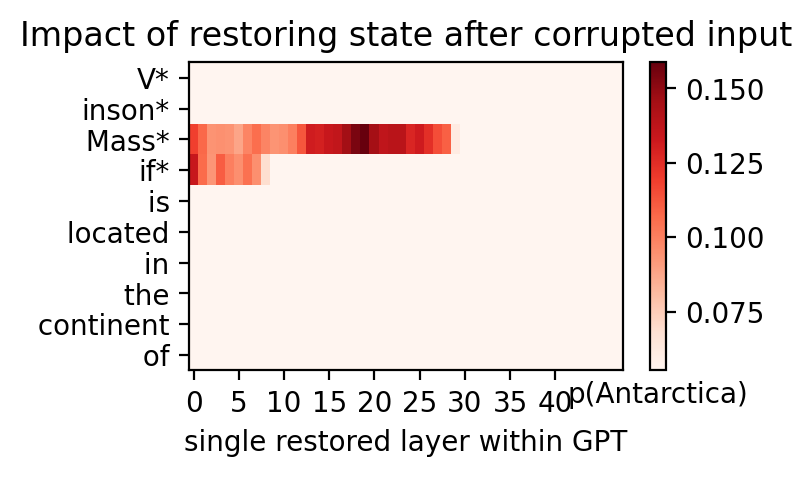

In [33]:
plot_trace_heatmap(result)